# Model Representation Examples
## Produce the AskeNet Model Representation of "toy" SIR-based models by converting from template to MIRA to Aske representations.

In [1]:
from collections.abc import Callable

In [21]:
import mira
from mira.sources.askenet import model_from_url
from mira.metamodel import Concept, ControlledConversion, GroupedControlledConversion, Initial, NaturalConversion, Parameter, Template, TemplateModel
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
import torch
from pyciemss.interfaces import setup_model, calibrate, intervene
from pyciemss.PetriNetODE.interfaces import load_petri_model, setup_petri_model
from collections.abc import Callable
from typing import Tuple
import sympy
import sympytorch

In [19]:
import pandas as pd
df = pd.DataFrame({'loc': [1123, 'US']})
df['loc'].astype(str).str[:2]

0    11
1    US
Name: loc, dtype: object

In [3]:
def make_model() -> Callable[[float, Tuple[torch.Tensor]], Tuple[torch.Tensor]]:
        """Compile the deriv function during initialization."""
        state_variables = "beta, total_population, susceptible_population, infectious_population, gamma, recovered_population"
        beta, total_pop,S, I, gamma, R = sympy.symbols(state_variables)
        susceptible = Concept(name="susceptible_population", identifiers={"ido": "0000514"})
        infectious = Concept(name="infectious_population", identifiers={"ido": "0000513"}) # http://purl.obolibrary.org/obo/IDO_0000513
        recovered = Concept(name="recovered_population", identifiers={"ido": "0000592"})
        
        # Set a value for the total population
        total_pop = 100000                                                                                                                                                                                                                           
        S_to_I = ControlledConversion(
            controller = infectious,
            subject=susceptible,
            outcome=infectious,
            rate_law=(beta/total_pop)*S*I
        )
        I_to_R = NaturalConversion(
            subject=infectious,
            outcome=recovered,
            rate_law=gamma*I
        )
        template_model = TemplateModel(
            templates=[S_to_I, I_to_R],
            parameters={
                'beta': Parameter(name='beta', value=0.55), # transmission rate
                'total_population': Parameter(name='total_population', value=total_pop),
                'gamma': Parameter(name='gamma', value=0.2), # recovery rate
            },
            initials={
                'susceptible_population': (Initial(concept=susceptible, value=total_pop-1)),
                'infectious_population': (Initial(concept=infectious, value=1)),
                'recovered_population': (Initial(concept=recovered, value=0))
            }
        )
        model=Model(template_model)
        return model

In [8]:
model = make_model()

## Biomodels

In [3]:
AMR_URL_TEMPLATE= "https://raw.githubusercontent.com/DARPA-ASKEM/experiments/main/thin-thread-examples/mira_v2/biomodels/{biomodel_id}/model_askenet.json"
biomodels = """BIOMD0000000249	BIOMD0000000716	BIOMD0000000949	BIOMD0000000956	BIOMD0000000960	BIOMD0000000964	BIOMD0000000971	BIOMD0000000976	BIOMD0000000979	BIOMD0000000982	BIOMD0000000988	MODEL1008060000	MODEL1805230001	MODEL2111170001 BIOMD0000000294	BIOMD0000000717	BIOMD0000000950	BIOMD0000000957	BIOMD0000000962	BIOMD0000000969	BIOMD0000000972	BIOMD0000000977	BIOMD0000000980	BIOMD0000000983	BIOMD0000000991	MODEL1008060002	MODEL1808280006
BIOMD0000000715	BIOMD0000000726	BIOMD0000000955	BIOMD0000000958	BIOMD0000000963	BIOMD0000000970	BIOMD0000000974	BIOMD0000000978	BIOMD0000000981	BIOMD0000000984	BIOMD0000001045	MODEL1805220001	MODEL1808280011""".split()
biomodels_tests = {biomodel_id: dict(source=AMR_URL_TEMPLATE.format(biomodel_id=biomodel_id))
                                for biomodel_id in biomodels}


In [43]:
import pyciemss
from sympytorch import SymPyModule
from pyciemss.PetriNetODE.base import get_name
import sympy
mira_template_model = model_from_url(biomodels_tests['BIOMD0000000979']['source'])
mira_model = mira.modeling.Model(mira_template_model)
model = pyciemss.PetriNetODE.base.ScaledBetaNoisePetriNetODESystem.from_askenet(mira_model)

symbolic_derivs = {get_name(var): sympy.sympify(0.0) for var in model.var_order.values()}
for t in model.G.transitions.values():
        print(t.template.rate_law)
        flux = model.extract_sympy(t.template.rate_law)
        print(flux.free_symbols)
        for c in t.consumed:
            symbolic_derivs[get_name(c)] -= flux
        for p in t.produced:
            symbolic_derivs[get_name(p)] += flux

        # convert to a function
        numeric_derivs = SymPyModule(expressions=[symbolic_derivs[get_name(k)] for k in model.var_order.values()])
flux

3.02981679061445e-9*Infected*R_fixed*Susceptible*gamma
{gamma, Infected, Susceptible, R_fixed}
Exposed*sigma
{Exposed, sigma}
Infected*gamma
{Infected, gamma}
Recovered*omega
{omega, Recovered}


Recovered*omega

In [40]:
symbolic_derivs

{'Exposed': 3.02981679061445e-9*Infected*R_fixed*Susceptible*gamma,
 'Infected': 0,
 'Recovered': 0,
 'Susceptible': -3.02981679061445e-9*Infected*R_fixed*Susceptible*gamma,
 'Total_population': 0}

In [20]:
load_petri_model(biomodels_tests['BIOMD0000000979']['source'], compile_rate_law_p=True)

AttributeError: 'int' object has no attribute 'func'

In [13]:
for biomodel_id, biomodel in biomodels_tests.items():
    try:
        print(biomodel_id)
        model = load_petri_model(biomodel['source'])
    except AttributeError as e:
        print(e)
    except KeyError as k:
        print(k)

BIOMD0000000249
BIOMD0000000716
BIOMD0000000949
'value'
BIOMD0000000956
'value'
BIOMD0000000960
'value'
BIOMD0000000964
BIOMD0000000971
BIOMD0000000976
BIOMD0000000979
BIOMD0000000982
'value'
BIOMD0000000988
MODEL1008060000
MODEL1805230001
MODEL2111170001
'value'
BIOMD0000000294
BIOMD0000000717
BIOMD0000000950
BIOMD0000000957
BIOMD0000000962
'value'
BIOMD0000000969
'value'
BIOMD0000000972
BIOMD0000000977
'value'
BIOMD0000000980
BIOMD0000000983
'value'
BIOMD0000000991
'value'
MODEL1008060002
MODEL1808280006
BIOMD0000000715
BIOMD0000000726
BIOMD0000000955
BIOMD0000000958
BIOMD0000000963
'value'
BIOMD0000000970
BIOMD0000000974
BIOMD0000000978
'value'
BIOMD0000000981
BIOMD0000000984
BIOMD0000001045
MODEL1805220001
'value'
MODEL1808280011


## SIDARTHE

In [4]:
from pyciemss.PetriNetODE.base import get_name
sidarthe_amr = '../../test/models/AMR_examples/BIOMD0000000955_askenet.json'
raw_sidarthe = load_petri_model(sidarthe_amr)



/Users/zuck016/Projects/Proposals/ASKEM/build/clean-build/src/pyciemss/PetriNetODE/base.py:330: UserWarning: Parameter (('Infected', ('identity', 'ido:0000511')), ('Healed', ('identity', 'ido:0000592')), 'NaturalConversion', 'rate') has value None and will be set to Uniform(0, 1)
  warnings.warn(warnings_string)


In [17]:
from mira.sources.askenet import model_from_json_file, model_from_url
template_model = model_from_json_file(sidarthe_amr)
assert 'lambda' in template_model.parameters
model = mira.modeling.Model(template_model)
assert 'lambda' in model.parameters

dict_keys(['beta', 'gamma', 'delta', 'alpha', 'epsilon', 'zeta', 'lambda', 'eta', 'rho', 'theta', 'kappa', 'mu', 'nu', 'xi', 'tau', 'sigma'])
dict_keys(['beta', 'gamma', 'delta', 'alpha', 'epsilon', 'zeta', (('Infected', ('identity', 'ido:0000511')), ('Healed', ('identity', 'ido:0000592')), 'NaturalConversion', 'rate'), 'eta', 'rho', 'theta', 'kappa', 'mu', 'nu', 'xi', 'tau', 'sigma'])


AssertionError: 

In [26]:
model.parameters[(('Infected', ('identity', 'ido:0000511')),
   ('Healed', ('identity', 'ido:0000592')),
   'NaturalConversion',
   'rate')].value is None

True

In [20]:
set(template_model.parameters.keys()) - set(model.parameters.keys()), set(model.parameters.keys()) - set(template_model.parameters.keys())


({'lambda'},
 {(('Infected', ('identity', 'ido:0000511')),
   ('Healed', ('identity', 'ido:0000592')),
   'NaturalConversion',
   'rate')})

In [5]:
start_state = {
            get_name(v): v.data["initial_value"] for v in raw_sidarthe.G.variables.values()
        }

In [6]:
sidarthe = setup_petri_model(raw_sidarthe, 0.0, start_state)

In [7]:
sidarthe.G.parameters

{'beta': <mira.modeling.ModelParameter at 0x157b0bc70>,
 'gamma': <mira.modeling.ModelParameter at 0x10db03b20>,
 'delta': <mira.modeling.ModelParameter at 0x10db37490>,
 'alpha': <mira.modeling.ModelParameter at 0x157b0bfa0>,
 'epsilon': <mira.modeling.ModelParameter at 0x157b0be50>,
 'zeta': <mira.modeling.ModelParameter at 0x157b481c0>,
 (('Infected', ('identity', 'ido:0000511')),
  ('Healed', ('identity', 'ido:0000592')),
  'NaturalConversion',
  'rate'): <mira.modeling.ModelParameter at 0x157b48310>,
 'eta': <mira.modeling.ModelParameter at 0x157b48370>,
 'rho': <mira.modeling.ModelParameter at 0x157b485b0>,
 'theta': <mira.modeling.ModelParameter at 0x157b48700>,
 'kappa': <mira.modeling.ModelParameter at 0x157b48760>,
 'mu': <mira.modeling.ModelParameter at 0x157b48850>,
 'nu': <mira.modeling.ModelParameter at 0x157b48a90>,
 'xi': <mira.modeling.ModelParameter at 0x157b48be0>,
 'tau': <mira.modeling.ModelParameter at 0x157b48d30>,
 'sigma': <mira.modeling.ModelParameter at 0x157

In [7]:
import sympy, torch, sympytorch
from torch import tensor
total_pop, S, I, R, beta, gamma = sympy.symbols('total_pop, S, I, R, beta, gamma')
S_to_I = beta*I*S/total_pop
I_to_R = gamma*I

# = sympytorch.SymPyModule(expressions=[S_to_I, I_to_R])
dSdt = -S_to_I
dIdt = S_to_I - I_to_R
dRdt = I_to_R

compile_deriv = sympytorch.SymPyModule(expressions=[dSdt, dIdt, dRdt])

compiled_deriv = compile_deriv(beta=getattr(self, 'beta'),
      gamma=getattr(self, 'gamma'),
      S=states['S'],
      I=states['I'],
      R=states['R'],
      total_pop=sum(states[i] for i in states)
     )

compile_deriv(beta=tensor(1.),
              gamma=tensor(1.),
              S=tensor(99.),
              I=tensor(1.),
              R=tensor(0.0),
              total_pop=tensor(100.)
             )

tensor([-0.9900, -0.0100,  1.0000])

In [ ]:
      
x_ = torch.rand(3)
out = mod(x_name=x_)  # out has shape (3, 2)

assert torch.equal(out[:, 0], x_.cos())
assert torch.equal(out[:, 1], 2 * x_.sin())
assert out.requires_grad  # from the two Parameters initialised as 1.0 and 2.0
assert {x.item() for x in mod.parameters()} == {1.0, 2.0}

In [ ]:
def get_fluxes(rate_law):
    
    

## Define `Concepts` (model state variables) and total population

In [2]:
susceptible = Concept(name="susceptible_population", identifiers={"ido": "0000514"})
exposed = Concept(name="exposed_population", identifiers={"ido": "0000594"}) # http://purl.obolibrary.org/obo/IDO_0000594
infectious = Concept(name="infectious_population", identifiers={"ido": "0000513"}) # http://purl.obolibrary.org/obo/IDO_0000513
symptomatic = Concept(name="symptomatic_population", identifiers={"ido": "0000573"}) # http://purl.obolibrary.org/obo/IDO_0000573
asymptomatic = Concept(name="asymptomatic_population", identifiers={"ido": "0000569"}) # http://purl.obolibrary.org/obo/IDO_0000569
recovered = Concept(name="recovered_population", identifiers={"ido": "0000592"})
hospitalized = Concept(name="hospitalized_population", identifiers={"ncit": "C25179"})
deceased = Concept(name="deceased_population", identifiers={"ncit": "C168970"}) # http://purl.obolibrary.org/obo/NCIT_C168970

# Set a value for the total population
total_pop = 100000

# Model 1: SIRHD
Model 1 state variables: Susceptible (S), Infectious (I), Recovered (R), Hospitalized (H), and Deceased (D)

## Define conversion templates for Model 1

In [3]:
state_variables = "beta, total_population, susceptible_population, delta, infectious_population, gamma, hosp, dnh, dh, los, hospitalized_population, recovered_population, deceased_population"
beta, N, S, delta, I, gamma, hosp, dnh, dh, los, H, R, D = sympy.symbols(state_variables)
                                                                                                                                                                                                                            
S_to_I = ControlledConversion(
    controller = infectious,
    subject=susceptible,
    outcome=infectious,
    rate_law=(beta/N)*S*I
)
I_to_R = NaturalConversion(
    subject=infectious,
    outcome=recovered,
    rate_law=gamma*(1-hosp-dnh)*I
)
I_to_H = NaturalConversion(
    subject=infectious,
    outcome=hospitalized,
    rate_law=gamma*hosp*I
)
I_to_D = NaturalConversion(
    subject=infectious,
    outcome=deceased,
    rate_law=gamma*dnh*I
)
H_to_R = NaturalConversion(
    subject=hospitalized,
    outcome=recovered,
    rate_law=((1-dh)/los)*H
)
H_to_D = NaturalConversion(
    subject=hospitalized,
    outcome=deceased,
    rate_law=(dh/los)*H
)

# display(S_to_E.rate_law.args[0])

## Set up the template model, define parameter values and initial conditions

In [4]:
tm1 = TemplateModel(
    templates=[S_to_I, I_to_R, I_to_H, I_to_D, H_to_R, H_to_D],
    parameters={
        'beta': Parameter(name='beta', value=0.55), # transmission rate
        'total_population': Parameter(name='total_population', value=total_pop),
        'gamma': Parameter(name='gamma', value=0.2), # recovery rate
        'hosp': Parameter(name='hosp', value=0.1), # hospitalization rate of infectious individuals
        'dnh': Parameter(name='dnh', value=0.001), # death rate of infectious individuals (never hospitalized)
        'dh': Parameter(name='dh', value=0.1), #  death rate of infectious individuals (hospitalized)
        'los': Parameter(name='los', value=7), # average length (days) of hospital stay
    },
    initials={
        'susceptible_population': (Initial(concept=susceptible, value=(total_pop - 1))), 
        'infectious_population': (Initial(concept=infectious, value=1)),
        'hospitalized_population': (Initial(concept=hospitalized, value=0)),
        'recovered_population': (Initial(concept=recovered, value=0)),
        'deceased_population': (Initial(concept=deceased, value=0)),
    }
)

display(type(tm1)) # confirm that tm is a TemplateModel
# display(tm.dict())

mira.metamodel.template_model.TemplateModel

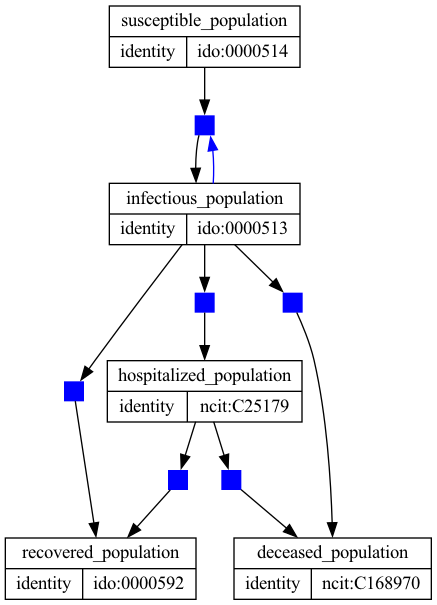

In [5]:
# Visualize the TemplateModel
GraphicalModel.for_jupyter(tm1, width="20%")

## Convert to MIRA model representation

In [6]:
mira_m1 = Model(tm1)
display(type(mira_m1)) 
#mira_m.variables

mira.modeling.Model

## Convert to AskeNet Model Representation (AMR) and output JSON file

In [7]:
aske_m1 = AskeNetPetriNetModel(mira_m1)

# Display AMR model in JSON format
display(aske_m1.to_json())

# Save AMR model as JSON file
aske_m1.to_json_file("SIRHD_AMR.json", indent=2)

{'name': 'Model',
 'schema': 'https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/petrinet_v0.5/petrinet/petrinet_schema.json',
 'schema_name': 'petrinet',
 'description': 'Model',
 'model_version': '0.1',
 'properties': {},
 'model': {'states': [{'id': 'susceptible_population',
    'name': 'susceptible_population',
    'grounding': {'identifiers': {'ido': '0000514'}, 'modifiers': {}}},
   {'id': 'infectious_population',
    'name': 'infectious_population',
    'grounding': {'identifiers': {'ido': '0000513'}, 'modifiers': {}}},
   {'id': 'recovered_population',
    'name': 'recovered_population',
    'grounding': {'identifiers': {'ido': '0000592'}, 'modifiers': {}}},
   {'id': 'hospitalized_population',
    'name': 'hospitalized_population',
    'grounding': {'identifiers': {'ncit': 'C25179'}, 'modifiers': {}}},
   {'id': 'deceased_population',
    'name': 'deceased_population',
    'grounding': {'identifiers': {'ncit': 'C168970'}, 'modifiers': {}}}],
  'transitions': [

In [8]:
# Import mira_m the pyciemss way
the_model = load_petri_model(mira_m1) 
the_model

ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.4950000047683716, high: 0.6050000190734863),
	total_population = Uniform(low: 90000.0, high: 110000.0),
	(('susceptible_population', ('identity', 'ido:0000514')), ('infectious_population', ('identity', 'ido:0000513')), ('infectious_population', ('identity', 'ido:0000513')), 'ControlledConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	gamma = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	hosp = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	dnh = Uniform(low: 0.0008999999845400453, high: 0.0010999999940395355),
	(('infectious_population', ('identity', 'ido:0000513')), ('recovered_population', ('identity', 'ido:0000592')), 'NaturalConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	(('infectious_population', ('identity', 'ido:0000513')), ('hospitalized_population', ('identity', 'ncit:C25179')), 'NaturalConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	(('infectious_population', ('identity',

In [15]:
sirhd_amr = load_petri_model("SIRHD_AMR.json")
sirhd_amr 

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 4.949999947712058e-06, high: 6.050000138202449e-06),
	mira_param_1 = Uniform(low: 0.16181999444961548, high: 0.19777999818325043),
	mira_param_2 = Uniform(low: 0.017999999225139618, high: 0.02199999988079071),
	mira_param_3 = Uniform(low: 0.00018000000272877514, high: 0.00022000000171829015),
	mira_param_4 = Uniform(low: 0.11571428924798965, high: 0.14142857491970062),
	mira_param_5 = Uniform(low: 0.012857142835855484, high: 0.015714285895228386),
	pseudocount = 1.0
)

# Model 2: SEIARHD
Model 2 state variables: Susceptible (S), Exposed (E), Symptomatic Infectious (I), Asymptomatic Infectious (A), Recovered (R), Hospitalized (H), <br> and Deceased (D)

## Define conversion templates for Model 2

In [10]:
state_variables = "beta, total_population, susceptible_population, delta, symptomatic_population, asymptomatic_population, pS, alpha, exposed_population, gamma, hosp, dnh, dh, los, hospitalized_population, recovered_population, deceased_population"
beta, N, S, delta, I, A, pS, alpha, E, gamma, hosp, dnh, dh, los, H, R, D = sympy.symbols(state_variables)
                                                                                                                                                                                                                            
S_to_E = GroupedControlledConversion(
    controllers = [
        symptomatic, 
        asymptomatic, 
    ],
    subject=susceptible,
    outcome=exposed,
    rate_law=(beta/N)*S*(delta*I + A)
)
E_to_I = NaturalConversion(
    subject=exposed,
    outcome=symptomatic,
    rate_law=(pS/alpha)*E
)
E_to_A = NaturalConversion(
    subject=exposed,
    outcome=asymptomatic,
    rate_law=((1-pS)/alpha)*E
)
I_to_R = NaturalConversion(
    subject=symptomatic,
    outcome=recovered,
    rate_law=gamma*(1-hosp-dnh)*I
)
I_to_H = NaturalConversion(
    subject=symptomatic,
    outcome=hospitalized,
    rate_law=gamma*hosp*I
)
I_to_D = NaturalConversion(
    subject=symptomatic,
    outcome=deceased,
    rate_law=gamma*dnh*I
)
A_to_R = NaturalConversion(
    subject=asymptomatic,
    outcome=recovered,
    rate_law=gamma*A
)
H_to_R = NaturalConversion(
    subject=hospitalized,
    outcome=recovered,
    rate_law=((1-dh)/los)*H
)
H_to_D = NaturalConversion(
    subject=hospitalized,
    outcome=deceased,
    rate_law=(dh/los)*H
)

# display(S_to_E.rate_law.args[0])

## Set up the template model, define parameter values and initial conditions

In [11]:
tm2 = TemplateModel(
    templates=[S_to_E, E_to_I, E_to_A, I_to_R, I_to_H, I_to_D, A_to_R, H_to_R, H_to_D],
    parameters={
        'beta': Parameter(name='beta', value=0.55), # transmission rate
        'total_population': Parameter(name='total_population', value=total_pop),
        'delta': Parameter(name='delta', value=1.5), # difference in infectiousness symptomatic/asymptomatic
        'pS': Parameter(name='pS', value=0.7), # percent of exposures which become symptomatic
        'alpha': Parameter(name='alpha', value=4), # latency period
        'gamma': Parameter(name='gamma', value=0.2), # recovery rate
        'hosp': Parameter(name='hosp', value=0.1), # hospitalization rate of infectious individuals
        'dnh': Parameter(name='dnh', value=0.001), # death rate of infectious individuals (never hospitalized)
        'dh': Parameter(name='dh', value=0.1), #  death rate of infectious individuals (hospitalized)
        'los': Parameter(name='los', value=7), # average length (days) of hospital stay
    },
    initials={
        'susceptible_population': (Initial(concept=susceptible, value=(total_pop - 1))), 
        'symptomatic_population': (Initial(concept=symptomatic, value=1)),
        'asymptomatic_population': (Initial(concept=asymptomatic, value=0)),
        'exposed_population': (Initial(concept=exposed, value=0)),
        'hospitalized_population': (Initial(concept=hospitalized, value=0)),
        'recovered_population': (Initial(concept=recovered, value=0)),
        'deceased_population': (Initial(concept=deceased, value=0)),
    }
)

display(type(tm2)) # confirm that tm is a TemplateModel
# display(tm.dict())

mira.metamodel.template_model.TemplateModel

In [55]:
type(tm2.templates[0].rate_law)


mira.metamodel.templates.SympyExprStr

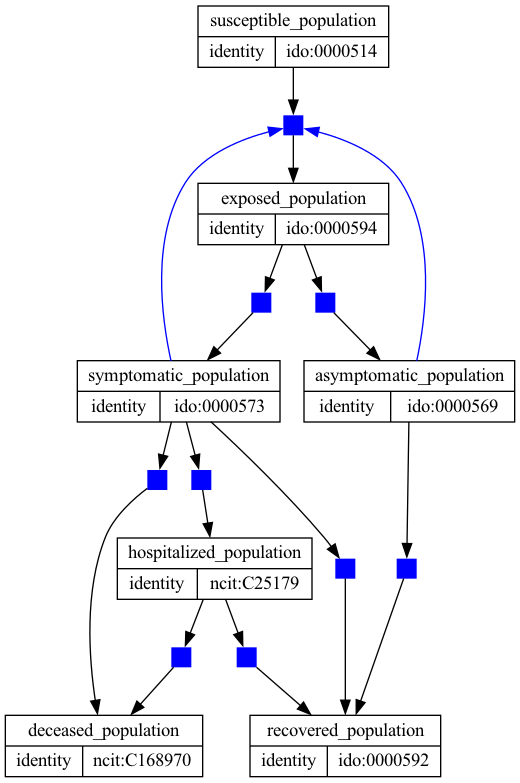

In [12]:
# Visualize the TemplateModel
GraphicalModel.for_jupyter(tm2, width="20%")

## Convert to MIRA model representation 

In [13]:
mira_m2 = Model(tm2)
display(type(mira_m2)) 
#mira_m.variables

mira.modeling.Model

## Convert to AskeNet Model Representation (AMR) and output JSON file

In [14]:
aske_m2 = AskeNetPetriNetModel(mira_m2)

# Display AMR model in JSON format
display(aske_m2.to_json())

# Save AMR model as JSON file
aske_m2.to_json_file("SEIARHD_AMR.json", indent=2)

{'name': 'Model',
 'schema': 'https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/petrinet_v0.5/petrinet/petrinet_schema.json',
 'schema_name': 'petrinet',
 'description': 'Model',
 'model_version': '0.1',
 'properties': {},
 'model': {'states': [{'id': 'susceptible_population',
    'name': 'susceptible_population',
    'grounding': {'identifiers': {'ido': '0000514'}, 'modifiers': {}}},
   {'id': 'symptomatic_population',
    'name': 'symptomatic_population',
    'grounding': {'identifiers': {'ido': '0000573'}, 'modifiers': {}}},
   {'id': 'asymptomatic_population',
    'name': 'asymptomatic_population',
    'grounding': {'identifiers': {'ido': '0000569'}, 'modifiers': {}}},
   {'id': 'exposed_population',
    'name': 'exposed_population',
    'grounding': {'identifiers': {'ido': '0000594'}, 'modifiers': {}}},
   {'id': 'recovered_population',
    'name': 'recovered_population',
    'grounding': {'identifiers': {'ido': '0000592'}, 'modifiers': {}}},
   {'id': 'hospitali

In [17]:
# Import mira_m the pyciemss way
the_model = load_petri_model(mira_m2) 
the_model

ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.4950000047683716, high: 0.6050000190734863),
	delta = Uniform(low: 1.350000023841858, high: 1.649999976158142),
	total_population = Uniform(low: 90000.0, high: 110000.0),
	(('susceptible_population', ('identity', 'ido:0000514')), ('exposed_population', ('identity', 'ido:0000594')), (('symptomatic_population', ('identity', 'ido:0000573')), ('asymptomatic_population', ('identity', 'ido:0000569'))), 'GroupedControlledConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	alpha = Uniform(low: 3.5999999046325684, high: 4.400000095367432),
	pS = Uniform(low: 0.6299999952316284, high: 0.7699999809265137),
	(('exposed_population', ('identity', 'ido:0000594')), ('symptomatic_population', ('identity', 'ido:0000573')), 'NaturalConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	(('exposed_population', ('identity', 'ido:0000594')), ('asymptomatic_population', ('identity', 'ido:0000569')), 'NaturalConversion', 'rate') = Uniform(low: 0.0, hig

In [18]:
SEIARHD_amr = load_petri_model("SEIARHD_AMR.json")
SEIARHD_amr

ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.4950000047683716, high: 0.6050000190734863),
	delta = Uniform(low: 1.350000023841858, high: 1.649999976158142),
	total_population = Uniform(low: 90000.0, high: 110000.0),
	(('susceptible_population', ('identity', 'ido:0000514')), ('exposed_population', ('identity', 'ido:0000594')), (('asymptomatic_population', ('identity', 'ido:0000569')), ('symptomatic_population', ('identity', 'ido:0000573'))), 'GroupedControlledConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	mira_param_0 = Uniform(low: 0.1574999988079071, high: 0.19249999523162842),
	mira_param_1 = Uniform(low: 0.06750000268220901, high: 0.08250000327825546),
	mira_param_2 = Uniform(low: 0.16181999444961548, high: 0.19777999818325043),
	mira_param_3 = Uniform(low: 0.017999999225139618, high: 0.02199999988079071),
	mira_param_4 = Uniform(low: 0.00018000000272877514, high: 0.00022000000171829015),
	mira_param_5 = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),

# Model 3: SEIARHDS
Model 3 state variables: Susceptible (S), Exposed (E), Symptomatic Infectious (I), Asymptomatic Infectious (A), Recovered (R), Hospitalized (H), <br> and Deceased (D)

## Define conversion templates for Model 1

In [50]:
state_variables = "beta, total_population, susceptible_population, delta, symptomatic_population, asymptomatic_population, pS, alpha, exposed_population, gamma, hosp, dnh, dh, los, hospitalized_population, recovered_population, deceased_population, tau"
beta, N, S, delta, I, A, pS, alpha, E, gamma, hosp, dnh, dh, los, H, R, D, tau = sympy.symbols(state_variables)
                                                                                                                                                                                                                            
S_to_E = GroupedControlledConversion(
    controllers = [
        symptomatic, 
        asymptomatic, 
    ],
    subject=susceptible,
    outcome=exposed,
    rate_law=(beta/N)*S*(delta*I + A)
)
E_to_I = NaturalConversion(
    subject=exposed,
    outcome=symptomatic,
    rate_law=(pS/alpha)*E
)
E_to_A = NaturalConversion(
    subject=exposed,
    outcome=asymptomatic,
    rate_law=((1-pS)/alpha)*E
)
I_to_R = NaturalConversion(
    subject=symptomatic,
    outcome=recovered,
    rate_law=gamma*(1-hosp-dnh)*I
)
I_to_H = NaturalConversion(
    subject=symptomatic,
    outcome=hospitalized,
    rate_law=gamma*hosp*I
)
I_to_D = NaturalConversion(
    subject=symptomatic,
    outcome=deceased,
    rate_law=gamma*dnh*I
)
A_to_R = NaturalConversion(
    subject=asymptomatic,
    outcome=recovered,
    rate_law=gamma*A
)
H_to_R = NaturalConversion(
    subject=hospitalized,
    outcome=recovered,
    rate_law=((1-dh)/los)*H
)
H_to_D = NaturalConversion(
    subject=hospitalized,
    outcome=deceased,
    rate_law=(dh/los)*H
)
R_to_S = NaturalConversion(
    subject=recovered,
    outcome=susceptible,
    rate_law=(1/tau)*R
)

display(S_to_E.rate_law.args[0])

beta*susceptible_population*(asymptomatic_population + delta*symptomatic_population)/total_population

## Set up the template model, define parameter values and initial conditions

In [20]:
tm3 = TemplateModel(
    templates=[S_to_E, E_to_I, E_to_A, I_to_R, I_to_H, I_to_D, A_to_R, H_to_R, H_to_D, R_to_S],
    parameters={
        'beta': Parameter(name='beta', value=0.55), # transmission rate
        'total_population': Parameter(name='total_population', value=total_pop),
        'delta': Parameter(name='delta', value=1.5), # difference in infectiousness symptomatic/asymptomatic
        'pS': Parameter(name='pS', value=0.7), # percent of exposures which become symptomatic
        'alpha': Parameter(name='alpha', value=4), # latency period
        'gamma': Parameter(name='gamma', value=0.2), # recovery rate
        'hosp': Parameter(name='hosp', value=0.1), # hospitalization rate of infectious individuals
        'dnh': Parameter(name='dnh', value=0.001), # death rate of infectious individuals (never hospitalized)
        'dh': Parameter(name='dh', value=0.1), #  death rate of infectious individuals (hospitalized)
        'los': Parameter(name='los', value=7), # average length (days) of hospital stay
        'tau': Parameter(name='tau', value=30), # period of immunity from recovery (days)
    },
    initials={
        'susceptible_population': (Initial(concept=susceptible, value=(total_pop - 1))), 
        'symptomatic_population': (Initial(concept=symptomatic, value=1)),
        'asymptomatic_population': (Initial(concept=asymptomatic, value=0)),
        'exposed_population': (Initial(concept=exposed, value=0)),
        'hospitalized_population': (Initial(concept=hospitalized, value=0)),
        'recovered_population': (Initial(concept=recovered, value=0)),
        'deceased_population': (Initial(concept=deceased, value=0)),
    }
)

display(type(tm3)) # confirm that tm is a TemplateModel
# display(tm.dict())

mira.metamodel.template_model.TemplateModel

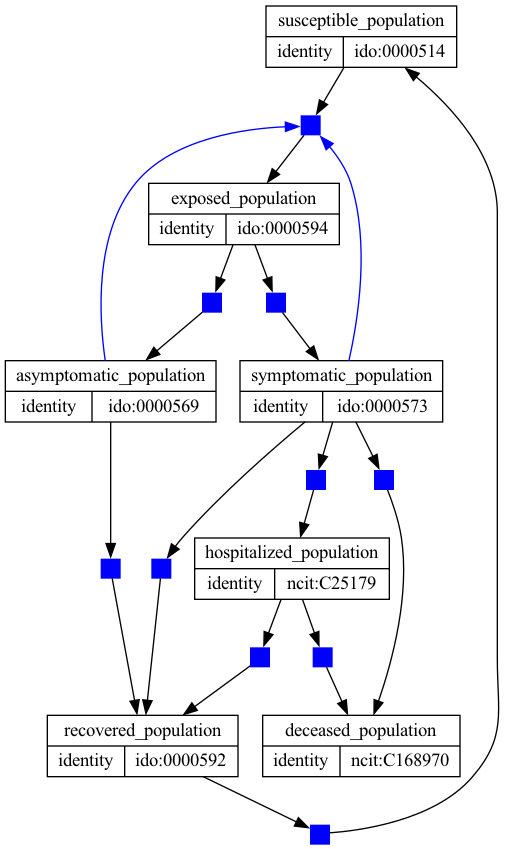

In [21]:
# Visualize the TemplateModel
GraphicalModel.for_jupyter(tm3, width="20%")

## Convert to MIRA model representation

In [51]:
mira_m3 = Model(tm3)
#display(type(mira_m3)) 
for t in mira_m3.template_model.transitions:
    r = mira_m3.template_model.transitions[t].rate_law
    print(r)

AttributeError: 'TemplateModel' object has no attribute 'transitions'

## Convert to AskeNet Model Representation (AMR) and output JSON file

In [24]:
aske_m3 = AskeNetPetriNetModel(mira_m3)

# Display AMR model in JSON format
display(aske_m3.to_json())

# Save AMR model as JSON file
aske_m3.to_json_file("SEIARHDS_AMR.json", indent=2)

{'name': 'Model',
 'schema': 'https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/petrinet_v0.5/petrinet/petrinet_schema.json',
 'schema_name': 'petrinet',
 'description': 'Model',
 'model_version': '0.1',
 'properties': {},
 'model': {'states': [{'id': 'susceptible_population',
    'name': 'susceptible_population',
    'grounding': {'identifiers': {'ido': '0000514'}, 'modifiers': {}}},
   {'id': 'symptomatic_population',
    'name': 'symptomatic_population',
    'grounding': {'identifiers': {'ido': '0000573'}, 'modifiers': {}}},
   {'id': 'asymptomatic_population',
    'name': 'asymptomatic_population',
    'grounding': {'identifiers': {'ido': '0000569'}, 'modifiers': {}}},
   {'id': 'exposed_population',
    'name': 'exposed_population',
    'grounding': {'identifiers': {'ido': '0000594'}, 'modifiers': {}}},
   {'id': 'recovered_population',
    'name': 'recovered_population',
    'grounding': {'identifiers': {'ido': '0000592'}, 'modifiers': {}}},
   {'id': 'hospitali

In [36]:
# Import mira_m the pyciemss way
the_model = load_petri_model(mira_m3) 
the_model.G.transitions

TypeError: '<=' not supported between instances of 'Uniform' and 'int'

In [27]:
SEIARHDS_amr = load_petri_model("SEIARHDS_AMR.json")
SEIARHDS_amr

ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.4950000047683716, high: 0.6050000190734863),
	delta = Uniform(low: 1.350000023841858, high: 1.649999976158142),
	total_population = Uniform(low: 90000.0, high: 110000.0),
	(('susceptible_population', ('identity', 'ido:0000514')), ('exposed_population', ('identity', 'ido:0000594')), (('asymptomatic_population', ('identity', 'ido:0000569')), ('symptomatic_population', ('identity', 'ido:0000573'))), 'GroupedControlledConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	mira_param_0 = Uniform(low: 0.1574999988079071, high: 0.19249999523162842),
	mira_param_1 = Uniform(low: 0.06750000268220901, high: 0.08250000327825546),
	mira_param_2 = Uniform(low: 0.16181999444961548, high: 0.19777999818325043),
	mira_param_3 = Uniform(low: 0.017999999225139618, high: 0.02199999988079071),
	mira_param_4 = Uniform(low: 0.00018000000272877514, high: 0.00022000000171829015),
	mira_param_5 = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),

In [47]:
for t in SEIARHDS_amr.G.transitions:
    r = SEIARHDS_amr.G.transitions[t].rate
    print(r.key, r.value)


(('susceptible_population', ('identity', 'ido:0000514')), ('exposed_population', ('identity', 'ido:0000594')), (('asymptomatic_population', ('identity', 'ido:0000569')), ('symptomatic_population', ('identity', 'ido:0000573'))), 'GroupedControlledConversion', 'rate') Uniform(low: 0.0, high: 1.0)
mira_param_0 Uniform(low: 0.1574999988079071, high: 0.19249999523162842)
mira_param_1 Uniform(low: 0.06750000268220901, high: 0.08250000327825546)
mira_param_2 Uniform(low: 0.16181999444961548, high: 0.19777999818325043)
mira_param_3 Uniform(low: 0.017999999225139618, high: 0.02199999988079071)
mira_param_4 Uniform(low: 0.00018000000272877514, high: 0.00022000000171829015)
mira_param_5 Uniform(low: 0.18000000715255737, high: 0.2199999988079071)
mira_param_6 Uniform(low: 0.11571428924798965, high: 0.14142857491970062)
mira_param_7 Uniform(low: 0.012857142835855484, high: 0.015714285895228386)
mira_param_8 Uniform(low: 0.029999999329447746, high: 0.036666665226221085)
